In [35]:
# imports
import os
from skimage.measure import label,regionprops
from skimage.morphology import binary_opening, erosion, dilation, ball
from skimage.segmentation import watershed
from scipy import ndimage
from sklearn.mixture import BayesianGaussianMixture
from skimage.morphology import opening, closing, ball
from skimage.filters import gaussian
import numpy as np
import nrrd
from skimage.segmentation import morphological_geodesic_active_contour as gac
from skimage.segmentation import inverse_gaussian_gradient as igg
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import entropy

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './scripts')
from ImageSliceViewer3D import ImageSliceViewer3D as isv 

In [2]:
''' 
SUPPLEMENTARY FUNCTION : createSubVolumes
This function isolates the sub-volume of the image that we are interested in. 
This way, we can perform operations only on the pixels containing lesion and surrounding pixels (executes faster).
    
    INPUT:
            image         - the original CT volume;
            image_dict    - dictionary with CT metadata;
            mask          - the original mask with radiologist-defined ROIs;
            lprop         - regionprops object for the user-defined start point.
            
    OUTPUT:
            cylinder_subV - cylinder mask, which occupies same space as both image and mask sub-volumes;
            image_subV    - image sub-volume, which contains lesion plus surrounding voxels;
            mask_subV     - ground truth labels, which occupies same space as both image and cylinder sub-volumes.
            
'''

def createSubVolumes(image,image_dict,mask,lprop):
    
    # construct cylinder_image
    bbox = lprop.bbox  
    bbox_dims = [bbox[3]-bbox[0],bbox[4]-bbox[1],bbox[-1]-bbox[2]]
    
    # take a circle with radius larger than bounding box
#   R = bbox_dims[0]/2 + bbox_dims[1]/2  
    R = max(bbox_dims)*5/8       
    
    # isolate the centroid of the nodule -- this will be our preliminary marker 
    j,i,k = [round(i) for i in lprop.centroid] 

    circle_mask = np.zeros((image.shape[0],image.shape[1]),dtype=bool)
    num_rows,num_cols = circle_mask.shape

    row,col = np.meshgrid(range(num_rows),range(num_cols))
    circle_mask[((row-i)**2+(col-j)**2)<R**2] = True
            
    # now we have the initial contour (that will theoretically be user-defined for the clinical dataset)
    # next step: extend the circle in both superior and inferior directions to obtain a cylinder

    # determine the number of slices required in the z direction for full coverage
    num_slices = int(np.ceil((float(image_dict['pixel_spacing']) * R) / float(image_dict['slice_thickness'])/2))

    cylinder_image = np.zeros((image.shape[0],image.shape[1],image.shape[2]),dtype=bool)

    for i in range(k-num_slices,k+num_slices+1):
        cylinder_image[:,:,i] = circle_mask
                
    # label the mask into connected regions
    mask_labels = label(cylinder_image)
    mask_props = regionprops(mask_labels)

    coords = mask_props[0].bbox

    cylinder_subV = mask_props[0].image
    image_subV = image[coords[0]:coords[3],coords[1]:coords[4],coords[2]:coords[-1]]
    mask_subV = mask[coords[0]:coords[3],coords[1]:coords[4],coords[2]:coords[-1]]
    
    return cylinder_subV,image_subV,mask_subV,R

In [3]:
''' 
SUPPLEMENTARY FUNCTION : determineThreshold
This function determines a threshold separating candidate lesion voxels from surrounding lung paremchyma. 
It leverages the BayesianGaussianMixture functionality from sklearn. 
Since the pre-defined sub-volume contains both lesion and lung parenchyma pixels, density distribution 
of the pixels could be modeled by two Gaussian distributions: P(x|lesion) and P(x|parenchyma), 
where x was the pixel density. The mean values and variations of the two Gaussian distributions were 
then estimated by the expectation-maximization method.
    
    INPUT:
            image_subV    - the CT sub-volume;
            cylinder_subV - cylinder mask occupying the same space as the image_subV.
            
    OUTPUT:
            threshold     - floating point threshold (anything above this threshold is a candidate lesion voxel)
                     
'''

def determineThreshold(image_subV,cylinder_subV):
    
    # isolate the intensities within the cylinder
    intensities = image_subV[cylinder_subV]

    hist, bin_edges = np.histogram(intensities, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

    classif = BayesianGaussianMixture(n_components=2)
    classif.fit(intensities.reshape(-1,1))

    return np.mean(classif.means_)

In [4]:
# lists of image/mask files
img_path = './data/images'
msk_path = './data/masks'

all_images = sorted([os.path.join(img_path,f) for f in os.listdir(img_path)])
all_masks = sorted([os.path.join(msk_path,f) for f in os.listdir(msk_path)])

In [241]:
# first pass of segmentation pipeline
def segPipeline(imgList,mskList):
    
    # initialize lists for segmentation accuracy
    IoU_water = []
    IoU_actC = []
    IoU_backW = []
    IoU_backA = []
    num_lesions_per_patient = []
    patient_index = []
    mean_intensities = []
    mean_intensities_gradient = []
    entropy_gradient = []
    dice_water = []
    dice_actC = []

    lst_images = []
    lst_wsmasks = []
    lst_acmasks = []
    
    
    for i in range(len(imgList)):
        
        # read image and corresponding mask
        img_V,img_d = nrrd.read(imgList[i])
        msk_V,msk_d = nrrd.read(mskList[i])
        
        # if the image and mask do not have the same size, do not process
        if not (img_d['sizes'] == msk_d['sizes']).all():
            print('ERROR, {}: image and mask must be of the same size'.format(imgList[i]))
            continue
            
        # label the mask into connected regions
        lesion_labels,num_lesions = label(msk_V,return_num=True)
        lesion_props = regionprops(lesion_labels)
        
        num_lesions_per_patient.append(num_lesions)
        
        # for every lesion in the mask
        for obj in lesion_props:
            
            patient_index.append(i)
            
            # create the sub-volume of interest within the CT volume
            cyl_subV,img_subV,msk_subV,R = createSubVolumes(img_V,img_d,msk_V,obj)
            
            # calculate threshold using EM
            threshold = determineThreshold(img_subV,cyl_subV)

            binary_img = np.logical_and(np.logical_and(img_subV > threshold,img_subV > -850),img_subV < 200)
            binary_img[~msk_subV] = False
            binary_img_centroid = closing(opening(binary_img,ball(radius=int(0.1*R))),ball(radius=int(0.1*R)))
            avg_intensity = np.mean(img_subV[binary_img])
            mean_intensities.append(avg_intensity)
            
            # label the cylinder sub-volume into connected regions
            cyl_subV_labels = label(cyl_subV)
            cyl_subV_props = regionprops(cyl_subV_labels)

            # coordinates for the user-defined lesion centroid
            cyl_j,cyl_i,cyl_k = [round(i) for i in cyl_subV_props[0].centroid]
            
            # construct a marker image for the watershed
            marker_image = np.zeros((img_subV.shape[0],img_subV.shape[1],img_subV.shape[2]),dtype=np.uint8)
            marker_image[~binary_img] = 2         # background/lung parenchyma voxels
            marker_image[cyl_j,cyl_i,cyl_k] = 1   # user-defined lesion centroid

            # denoise image sub-volume
            denoised = gaussian(img_subV,multichannel=False)

            # try some funky stuff
            max_image = dilation(denoised,ball(2))
            min_image = erosion(denoised,ball(2))

            gradient_image = max_image - min_image
            gradient_image[~msk_subV] = np.min(gradient_image)
            
            mean_intensities_gradient.append(np.mean(gradient_image[binary_img]))
            ent_gradient = entropy(gradient_image[binary_img])
            entropy_gradient.append(ent_gradient)
            
            if avg_intensity < -150: #np.logical_or(ent_gradient<3,ent_gradient>9):
                gradient_image = (gradient_image - np.min(gradient_image))/(np.max(gradient_image)-np.min(gradient_image))
            
            # create distance matrix for the 3D bowl function
            row,col,slc = np.meshgrid(range(gradient_image.shape[0]),range(gradient_image.shape[1]),range(gradient_image.shape[2]))
            dist_matrix = np.sqrt((round(cyl_j) - row)**2 + (round(cyl_i) - col)**2 + ((round(cyl_k) - slc) * float(msk_d['slice_thickness']))**2)
            dist_matrix[dist_matrix>=R] = R
            dist_matrix = dist_matrix / R
            
            # modify the gradient image for watershed
            mod_gradient = gradient_image * dist_matrix
            
            # perform watershed segmentation
            water_initial = ~watershed(gradient_image,marker_image,connectivity=2)
            water_initial_mod = ~watershed(mod_gradient, marker_image,connectivity=2)
            
            # label the watershed mask into connected regions
            water_labels = label(water_initial_mod,background = np.min(water_initial_mod))
            water_props = regionprops(water_labels)
            
            # find the smallest region
            water_areas = [water_props[i].area for i in range(len(water_props))]
            ind = np.where(water_areas == np.min(water_areas))

            # create the mask
            water_mask = water_labels == water_props[ind[0][0]].label

#             equiv_R = round(water_props[ind[0][0]].equivalent_diameter * 0.15)

#             water_mask_open = binary_opening(water_mask,ball(radius = equiv_R))
            
            # FINALLY this initial segmentation is fed into the active contours function for further refinement
            refined_mask = gac(igg(img_subV), iterations = 1, init_level_set=water_mask, threshold = 0.5)
            
            # fill any holes in the final mask result (unlikely, but you never know)
            refined_mask = binary_fill_holes(refined_mask)

            lst_images.append(img_subV)
            lst_wsmasks.append(water_mask)
            lst_acmasks.append(refined_mask)

            IoU_water.append(np.count_nonzero(np.logical_and(water_mask,msk_subV)) / np.count_nonzero(np.logical_or(water_mask,msk_subV)))
            IoU_actC.append(np.count_nonzero(np.logical_and(refined_mask,msk_subV)) / np.count_nonzero(np.logical_or(refined_mask,msk_subV)))
            IoU_backW.append(np.count_nonzero(np.logical_and(~water_mask,~msk_subV)) / np.count_nonzero(np.logical_or(~water_mask,~msk_subV)))
            IoU_backA.append(np.count_nonzero(np.logical_and(~refined_mask,~msk_subV)) / np.count_nonzero(np.logical_or(~refined_mask,~msk_subV)))
            
            dice_water.append(np.sum(water_mask[msk_subV==True])*2.0 / (np.sum(water_mask) + np.sum(msk_subV)))
            dice_actC.append(np.sum(refined_mask[msk_subV==True])*2.0 / (np.sum(refined_mask) + np.sum(msk_subV)))
#         # calculate the patient-specific IoU
#         all_backIoU.append(np.count_nonzero(np.logical_and(~water_whole,~msk_V))/np.count_nonzero(np.logical_or(~water_whole,~msk_V)))
        
    return IoU_water,IoU_actC,IoU_backW,IoU_backA,num_lesions_per_patient,patient_index,mean_intensities,mean_intensities_gradient,entropy_gradient,dice_water,dice_actC, lst_images, lst_wsmasks, lst_acmasks
        

# run the pipeline
IoU_water,IoU_actC,IoU_backW,IoU_backA,num_lesions_per_patient,patient_index,mean_intensities,mean_intensities_gradient,entropy_gradient,dice_water,dice_actC, images_lst, wsmasks_lst, acmask_lst = segPipeline(all_images,all_masks)

In [316]:
# creating masks of the different regions in the grayscale images to be used for analysis

# Initializing the lists for the masks (binary masks and superimposition on original grayscales)

msk_norm = wsmasks_lst.copy()
msk_eroded = []
msk_dilated = []
img_norm = []
img_eroded = []
img_dilated = []
img_rim = []
img_core = []
img_pv =[]

# for each of our lesions
for i in range(np.shape(msk_norm)[0]):

    # create eroded and dilated versions of the mask
    # not necessary to save them in list, but nice to have on hand
    # maybe need to look at optimal erosion/dilation approach
    msk_eroded.append(erosion(msk_norm[i],ball(2)))
    msk_dilated.append(dilation(msk_norm[i],ball(2)))

    # applying the mask on the original grayscale image
    x = images_lst[i].copy()
    x[msk_norm[i] == False] = False
    img_norm.append(x)

    # applying the eroded mask on the original graysclae image
    y = images_lst[i].copy()
    y[msk_eroded[i] == False] = False
    img_eroded.append(y)

    # applying the dilated mask on the original graysclae image
    z = images_lst[i].copy()
    z[msk_dilated[i] == False] = False
    img_dilated.append(z)

    # isolating the rim of the tumor (original mask - eroded mask)
    xx = images_lst[i].copy()
    msk_xx = msk_norm[i]^msk_eroded[i]
    xx[msk_xx == False] = False
    img_rim.append(xx)

    # the core of the tumor is the same as applying the eroded mask on the original image
    yy = images_lst[i].copy()
    msk_yy = msk_eroded[i]
    yy[msk_yy == False] = False
    img_core.append(yy)

    # isolating the perivascular regionr (dilated mask - original mask)
    zz = images_lst[i].copy()
    msk_zz = msk_dilated[i]^msk_norm[i]
    zz[msk_zz == False] = False
    img_pv.append(zz)

# uncomment to visualize some of the results
#isv(img_core[0])


C:\Users\Andrew\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


The ANOVA p-value = 7.910325820758268e-15
The paired t-test p-value = 7.996402249548681e-09


C:\Users\Andrew\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


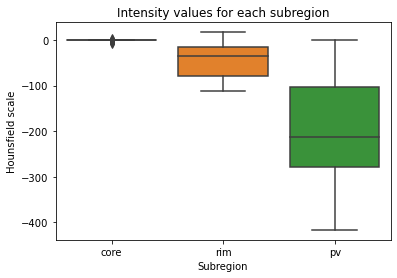

In [323]:
# Comparisons calculations that we could make

import seaborn as sns
import pandas as pd
from scipy import stats

# initialize dictionary for intensity values
intensities = {'core':[],'rim':[],'pv':[]}

# loop through each lesion mask and calculate the average intensity
for i in range(np.shape(img_core)[0]):
    intensities['core'].append(np.mean(img_core[i]))
    intensities['rim'].append(np.mean(img_rim[i]))
    intensities['pv'].append(np.mean(img_pv[i]))

# visualizing the intensity distributions
intensity_values = pd.DataFrame.from_dict(intensities)
fig, ax = plt.subplots()
ax = sns.boxplot(data=intensity_values)
ax.set_title('Intensity values for each subregion')
ax.set_xlabel('Subregion')
ax.set_ylabel('Hounsfield scale')

# ANOVA between the intensity calculations
f_value, p_value = stats.f_oneway(intensity_values['core'],intensity_values['rim'],intensity_values['pv'])
print('The ANOVA p-value = {}'.format(p_value))

# paired t-test between the rim and perivascular intensity calculations
t_value_paired, p_value_paired = stats.ttest_rel(intensity_values['rim'],intensity_values['pv'])
print('The paired t-test p-value = {}'.format(p_value_paired))

In [6]:
all_IoU_AC = (np.array(IoU_actC) + np.array(IoU_backA))/2
np.mean(all_IoU_AC)

0.6332229209013304

In [7]:
all_IoU_WS = (np.array(IoU_water) + np.array(IoU_backW))/2
np.mean(all_IoU_WS)

0.6953625526439772

In [8]:
from scipy.stats.stats import pearsonr

pearsonr(mean_intensities,IoU_actC)


(-0.026073200799444182, 0.9037437706773319)

(array([1., 1., 1., 1., 3., 3., 4., 4., 4., 2.]),
 array([0.50009196, 0.53214977, 0.56420757, 0.59626537, 0.62832317,
        0.66038097, 0.69243877, 0.72449657, 0.75655437, 0.78861217,
        0.82066997]),
 <BarContainer object of 10 artists>)

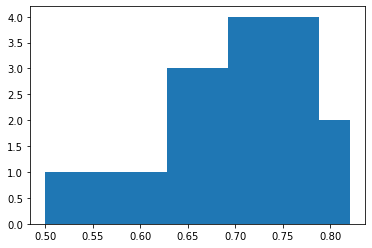

In [9]:
import matplotlib.pyplot as plt
plt.hist(all_IoU_WS)

Text(0, 0.5, 'Avg. IoU')

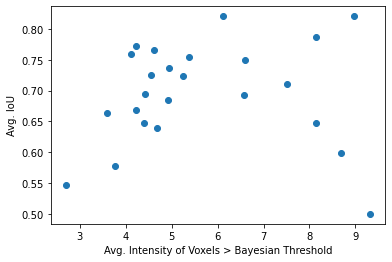

In [10]:
plt.scatter(entropy_gradient,all_IoU_WS)
plt.xlabel('Avg. Intensity of Voxels > Bayesian Threshold')
plt.ylabel('Avg. IoU')

In [11]:
# ALTERNATIVE EVALUATION METRIC : DICE COEFFICIENT
# seg = water_mask
# dice = np.sum(seg[msk_subV_true==True])*2.0 / (np.sum(seg) + np.sum(msk_subV_true))
# dice
mean_intensities_gradient

[0.013795232110752462,
 0.009078710026186645,
 0.015850235625835808,
 0.013546828788888698,
 0.008002433408362203,
 0.012939766125621116,
 0.023211095322344538,
 0.012166539354134824,
 0.008643839118727783,
 0.008384314751959452,
 0.008147052883136151,
 0.007939482818032306,
 0.01143822325521846,
 0.011881347621418459,
 0.012979862799354251,
 0.016637698390080318,
 0.016662091018221237,
 0.008671226401326329,
 0.00804924492977291,
 0.013748758840541397,
 0.02081448860969531,
 0.012412919181903282,
 0.01574158780816343,
 0.01017680060802046]

In [12]:
mean_intensities

[-85.13180008845643,
 -50.754500716377,
 -290.36708860759495,
 -179.10318471337578,
 -544.0912667191188,
 -200.5233695652174,
 -180.02325581395348,
 -138.03333333333333,
 -500.7536231884058,
 -472.49295774647885,
 -489.4578313253012,
 -483.75,
 -441.4274193548387,
 -318.9637305699482,
 4.975468331846566,
 -108.38137774413323,
 65.73333333333333,
 -475.73571428571427,
 -539.8032786885246,
 -356.0240963855422,
 -177.67142857142858,
 -360.03846153846155,
 -297.2318181818182,
 -278.6756756756757]

In [13]:
np.std(entropy_gradient)

1.849695626606395

In [14]:
np.mean(entropy_gradient) - 2 * np.std(entropy_gradient)

1.9557011343205457

In [15]:
dice_water

[0.8930241621200312,
 0.00045847023764040653,
 0.0,
 0.8734756097560976,
 0.5447049729451172,
 0.8477380148548278,
 0.3218390804597701,
 0.0,
 0.875,
 0.8307692307692308,
 0.6557377049180327,
 0.7904191616766467,
 0.0,
 0.8228228228228228,
 0.7330049261083744,
 0.38197289631263787,
 0.42105263157894735,
 0.7419354838709677,
 0.822429906542056,
 0.6875,
 0.6166666666666667,
 0.7932960893854749,
 0.0,
 0.5882352941176471]

In [16]:
HU = []
for i in range(len(dice_water)):
    if dice_water[i]<0.5:
        HU.append(mean_intensities[i])

In [17]:
HU

[-50.754500716377,
 -290.36708860759495,
 -180.02325581395348,
 -138.03333333333333,
 -441.4274193548387,
 -108.38137774413323,
 65.73333333333333,
 -297.2318181818182]